In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder 
from sklearn.decomposition import PCA
from sklearn import preprocessing 
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn import cluster
pd.set_option('display.max_rows', None) # 省略画图中的明细过程
plt.rcParams['font.sans-serif'] = ['SimHei']#中文编码

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     -------------------------------------- 282.6/282.6 kB 1.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## K—means聚类渠道广告效果分析

### 一、数据探索

本项目，通过各类广告渠道90天内额日均UV，平均注册率、平均搜索率、访问深度、平均停留时长、订单转化率、投放时间、素材类型、广告类型、合作方式、广告尺寸和广告卖点等特征，将渠道分类，找出每类渠道的重点特征，为业务讨论和数据分析提供支持。
数据13个维度介绍

渠道代号：渠道唯一标识

日均UV：每天的独立访问量

平均注册率=日均注册用户数/平均每日访问量

平均搜索量：每个访问的搜索量

访问深度：总页面浏览量/平均每天的访问量

平均停留时长=总停留时长/平均每天的访问量

订单转化率=总订单数量/平均每天的访客量

投放时间：每个广告在外投放的天数

素材类型：‘jpg’ ‘swf’ ‘gif’ ‘sp’

广告类型：banner. tips. 不确定. 横幅. 暂停

合作方式：‘roi’ ‘cpc’ ‘cpm’ ‘cpd’

广告尺寸：‘14040’ ‘308388’ ‘450300’ ‘60090’ ‘480360’ ‘960126’ ‘900120’
‘390270’

广告卖点：打折. 满减. 满赠. 秒杀. 直降. 满返

In [32]:
raw_data = pd.read_csv(r'D:\Learning\Data Analyse\Project\数据集\数据挖掘实战-渠道广告投放效果分析\ad_performance.csv')
raw_data.head()

,Unnamed: 0,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减
2,2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减
3,3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减
4,4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减


In [33]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  889 non-null    int64  
 1   渠道代号        889 non-null    object 
 2   日均UV        889 non-null    float64
 3   平均注册率       889 non-null    float64
 4   平均搜索量       889 non-null    float64
 5   访问深度        889 non-null    float64
 6   平均停留时间      887 non-null    float64
 7   订单转化率       889 non-null    float64
 8   投放总时间       889 non-null    int64  
 9   素材类型        889 non-null    object 
 10  广告类型        889 non-null    object 
 11  合作方式        889 non-null    object 
 12  广告尺寸        889 non-null    object 
 13  广告卖点        889 non-null    object 
dtypes: float64(6), int64(2), object(6)
memory usage: 97.4+ KB


In [34]:
raw_data[raw_data['平均停留时间'].isnull()]
raw_data = raw_data[raw_data['平均停留时间'].notnull()]

In [6]:
# 可以用pandas_profiling,更全面
from pandas_profiling import ProfileReport
ProfileReport(raw_data)

KeyboardInterrupt: 

## 数据清洗

In [35]:
# 观察Unnamed列
len(raw_data['Unnamed: 0'].unique()) == len(raw_data['Unnamed: 0'])
# drop掉'Unnamed: 0'
raw_data = raw_data.drop(['Unnamed: 0'],axis=1)
raw_data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减


In [ ]:
# 查看缺失情况
raw_data.isnull().sum()/len(raw_data['平均停留时间'])
# 查看具体缺失行
raw_data[raw_data['平均停留时间'].isnull()]
# 处理缺失值
raw_data = raw_data.dropna()

In [36]:
# 比率指标容易产生辛普森悖论，还原
raw_data['总UV']=raw_data['日均UV']*raw_data['投放总时间']
raw_data['注册总量']=raw_data['日均UV']*raw_data['平均注册率']*raw_data['投放总时间']
raw_data['总搜索量']=raw_data['平均搜索量']*raw_data['总UV']
raw_data['总页面浏览量']=raw_data['总UV']*raw_data['访问深度']
raw_data['总停留时间']=raw_data['总UV']*raw_data['平均停留时间']
raw_data['总订单数量']=raw_data['总UV']*raw_data['订单转化率']
raw_data['投放天数']=raw_data['投放总时间']
raw_data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点,总UV,注册总量,总搜索量,总页面浏览量,总停留时间,总订单数量,投放天数
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折,73.80,0.523980,1.57932,170.263980,30979.0260,1.904040,20
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减,3395.30,13.581200,110.00772,6956.630170,536253.6820,10.185900,19
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减,367.08,0.807576,19.45524,689.045868,131388.9444,0.954408,4
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减,10.90,0.080660,3.68638,46.244340,3968.3630,0.166770,10
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减,101.10,0.283080,17.59140,221.752740,31678.6740,0.070770,30


In [37]:
# drop掉原来的列
drop_list = ['日均UV','平均注册率','平均搜索量','访问深度','平均停留时间','订单转化率','投放总时间']
df = raw_data.drop(drop_list,axis=1)
df.head()

,渠道代号,素材类型,广告类型,合作方式,广告尺寸,广告卖点,总UV,注册总量,总搜索量,总页面浏览量,总停留时间,总订单数量,投放天数
0,A203,jpg,banner,roi,140*40,打折,73.80,0.523980,1.57932,170.263980,30979.0260,1.904040,20
1,A387,jpg,banner,cpc,140*40,满减,3395.30,13.581200,110.00772,6956.630170,536253.6820,10.185900,19
2,A388,jpg,banner,cpc,140*40,满减,367.08,0.807576,19.45524,689.045868,131388.9444,0.954408,4
3,A389,jpg,banner,cpc,140*40,满减,10.90,0.080660,3.68638,46.244340,3968.3630,0.166770,10
4,A390,jpg,banner,cpc,140*40,满减,101.10,0.283080,17.59140,221.752740,31678.6740,0.070770,30


In [ ]:
# 观察指标间的关系，其实在ProfileReport里有展示，但热力图更直观
import seaborn as sns
# pd.set_option('display.max_rows', None) # 省略画图中的明细过程
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
plt.rcParams['font.sans-serif'] = ['Sim Hei']#中文编码
corr = df.corr().round(2)
sns.set_style("darkgrid",{"font.sans-serif":['KaiTi', 'Arial']})
sns.heatmap(corr,cmap='Blues',annot=True)

In [38]:
# 可以看到数值变量之间相关性较强，可能产生较强的共线性，应用PCA降维
#分别处理label类和value类
label_list = ['素材类型','广告类型','合作方式','广告尺寸','广告卖点'] 
label_dummies = pd.get_dummies(df[label_list])

In [39]:
label_model = OneHotEncoder(sparse=False)
label_matrix = label_model.fit_transform(df[label_list])
label_matrix

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [40]:
value_list = df.drop(label_list,axis = 1)
value_list = value_list.drop('渠道代号',axis=1)
value_list = value_list.columns
value_list

Index(['总UV', '注册总量', '总搜索量', '总页面浏览量', '总停留时间', '总订单数量', '投放天数'], dtype='object')

In [41]:
df[value_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 888
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   总UV     887 non-null    float64
 1   注册总量    887 non-null    float64
 2   总搜索量    887 non-null    float64
 3   总页面浏览量  887 non-null    float64
 4   总停留时间   887 non-null    float64
 5   总订单数量   887 non-null    float64
 6   投放天数    887 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 55.4 KB


In [42]:
# 标准化
from sklearn.preprocessing import Normalizer
model = Normalizer()
value_scaled = model.fit_transform(df[value_list])
value_scaled

array([[2.38221371e-03, 1.69137173e-05, 5.09793733e-05, ...,
        9.99981848e-01, 6.14611136e-05, 6.45586370e-04],
       [6.33085859e-03, 2.53234343e-05, 2.05119818e-04, ...,
        9.99895805e-01, 1.89925758e-05, 3.54273004e-05],
       [2.79379302e-03, 6.14634464e-06, 1.48071030e-04, ...,
        9.99982335e-01, 7.26386185e-06, 3.04434240e-05],
       ...,
       [1.83890411e-03, 3.67780822e-07, 5.14893151e-06, ...,
        9.99996055e-01, 1.83890411e-07, 5.92182433e-06],
       [1.63046385e-03, 1.63046385e-07, 2.60874216e-06, ...,
        9.99996088e-01, 1.63046385e-07, 1.18978958e-06],
       [5.17242835e-04, 0.00000000e+00, 0.00000000e+00, ...,
        9.99628675e-01, 0.00000000e+00, 6.01445157e-04]])

In [43]:
# PCA降维
X_matrix = np.hstack((value_scaled,label_matrix))
pca_model = PCA(n_components=0.80) #要求降维后的数据保留90%的信息
after_pca = pd.DataFrame(pca_model.fit_transform(X_matrix))
after_pca

,0,1,2,3,4
0,0.186641,0.993744,-0.448127,-0.142281,0.321459
1,-0.873703,1.406147,-0.268380,0.131874,-0.297218
2,-0.873505,1.406395,-0.268432,0.131784,-0.297140
3,-0.873650,1.406223,-0.268394,0.131843,-0.297191
4,-0.873552,1.406339,-0.268419,0.131804,-0.297158
5,-0.873616,1.406266,-0.268402,0.131828,-0.297178
6,-0.873685,1.406173,-0.268382,0.131864,-0.297213
7,-0.873613,1.406261,-0.268404,0.131832,-0.297181
8,-0.873598,1.406280,-0.268408,0.131826,-0.297175
9,-0.873614,1.406260,-0.268404,0.131833,-0.297182


In [ ]:
col_list = ['col'+str(i) for i in range(1,len(after_pca.columns)+1)]
after_pca.columns = col_list
after_pca

## K-maens聚类

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Sim Hei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Sim Hei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Sim Hei


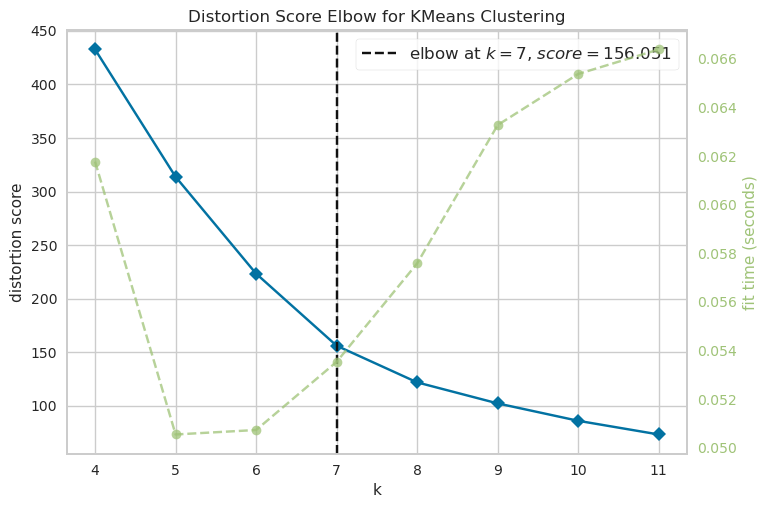

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
# 手肘法确定K值
Elbow = KElbowVisualizer(KMeans(),k=(4,12))
Elbow.fit(after_pca)
Elbow.show()

In [46]:
# 聚类，k=7
k_means_result = KMeans(7).fit_predict(after_pca)
k_re = pd.DataFrame(k_means_result,columns=['clusters'])
new_df = pd.concat((df,k_re),axis=1)
new_df.head()

,渠道代号,素材类型,广告类型,合作方式,广告尺寸,广告卖点,总UV,注册总量,总搜索量,总页面浏览量,总停留时间,总订单数量,投放天数,clusters
0,A203,jpg,banner,roi,140*40,打折,73.80,0.523980,1.57932,170.263980,30979.0260,1.904040,20.0,2.0
1,A387,jpg,banner,cpc,140*40,满减,3395.30,13.581200,110.00772,6956.630170,536253.6820,10.185900,19.0,2.0
2,A388,jpg,banner,cpc,140*40,满减,367.08,0.807576,19.45524,689.045868,131388.9444,0.954408,4.0,2.0
3,A389,jpg,banner,cpc,140*40,满减,10.90,0.080660,3.68638,46.244340,3968.3630,0.166770,10.0,2.0
4,A390,jpg,banner,cpc,140*40,满减,101.10,0.283080,17.59140,221.752740,31678.6740,0.070770,30.0,2.0


## 分析结果

D:\software\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution Of The Clusters')

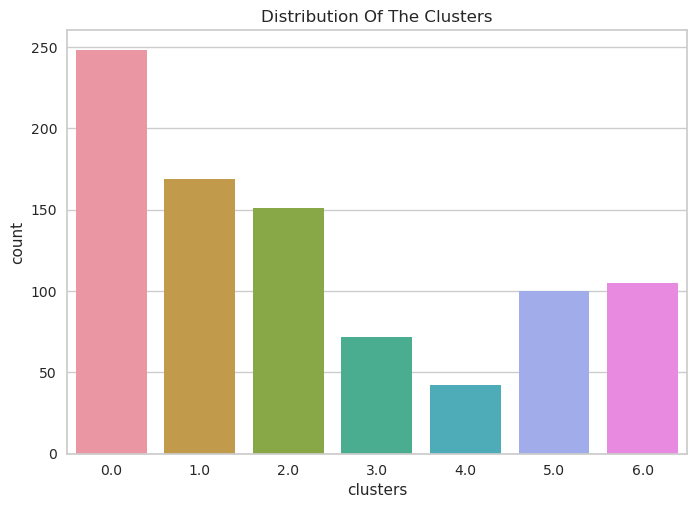

In [47]:
sns.countplot(new_df['clusters']).set_title("Distribution Of The Clusters")

### 成本分析

D:\software\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\software\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\software\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\software\anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


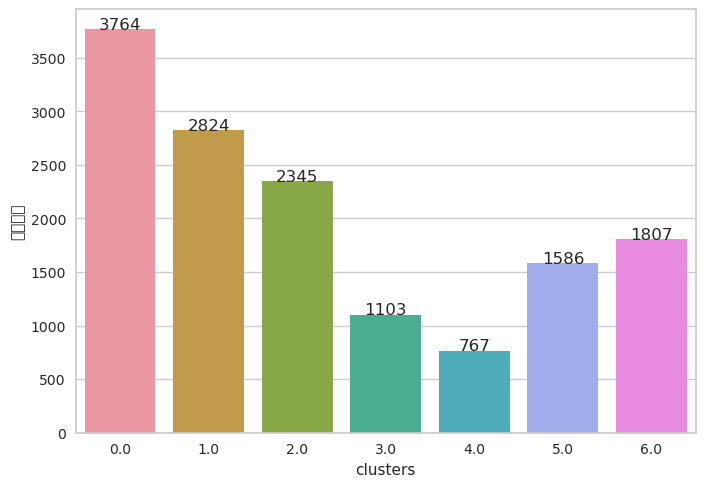

In [48]:
df_cost = new_df.groupby(['clusters'],as_index=False)['投放天数'].sum()
sns.barplot(x='clusters',y='投放天数',data=df_cost)
for x,y in zip(df_cost['clusters'],df_cost['投放天数']):
    plt.text(x=x,y=y,s='{:.0f}'.format(y),ha='center')

可以看到，投放天数主要集中于1，2，3渠道

<AxesSubplot:xlabel='clusters', ylabel='投放天数'>

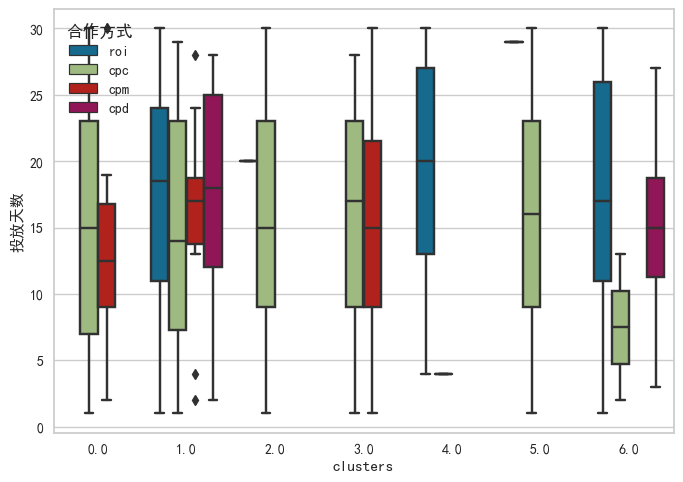

In [69]:
# 交叉合作方式
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']#中文编码
sns.boxplot(x='clusters',y='投放天数',hue='合作方式',data=new_df)

### 效果分析

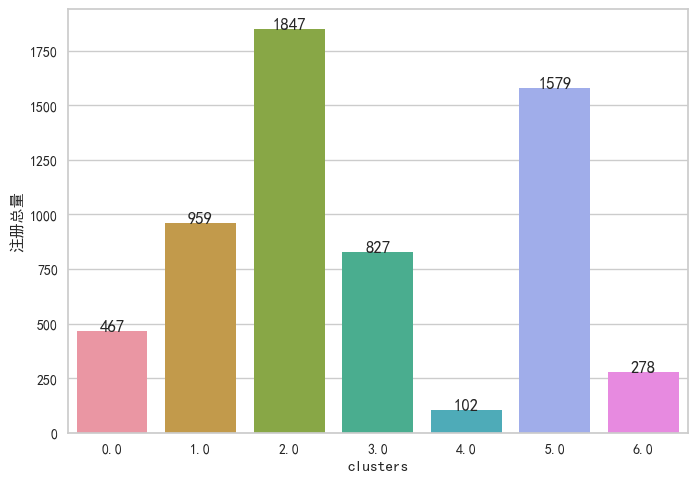

In [68]:
df_register = new_df.groupby(['clusters'],as_index=False)['注册总量'].sum()
sns.barplot(x='clusters',y='注册总量',data=df_register)
# # 增加数值标签
for x,y in zip(df_register['clusters'],df_register['注册总量']):
    plt.text(x=x,y=y,s='{:.0f}'.format(y),ha='center')

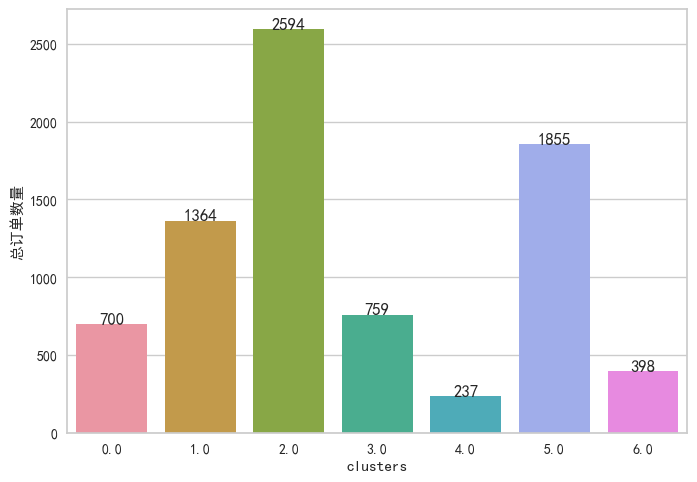

In [67]:
# 订单数,转化率
df_order = new_df.groupby(['clusters'],as_index=False)['总订单数量'].sum()
sns.barplot(x='clusters',y='总订单数量',data=df_order)
# # 增加数值标签
for x,y in zip(df_order['clusters'],df_order['总订单数量']):
    plt.text(x=x,y=y,s='{:.0f}'.format(y),ha='center')

In [52]:
# 综合上述指标
df_all = pd.concat([df_cost.set_index('clusters'),df_register.set_index('clusters'),df_order.set_index('clusters')],axis=1)
df_all['单位投放注册率'] = df_all['注册总量']/df_all['投放天数']
df_all['单位投放订单数'] = df_all['总订单数量']/df_all['投放天数']
df_all['转化率'] = df_all['总订单数量']/df_all['注册总量']
df_all

,投放天数,注册总量,总订单数量,单位投放注册率,单位投放订单数,转化率
clusters,,,,,,
0.0,3764.0,467.019616,700.450729,0.124075,0.186092,1.499831
1.0,2824.0,958.801754,1364.085165,0.339519,0.483033,1.422698
2.0,2345.0,1847.205211,2593.785326,0.787721,1.106092,1.404167
3.0,1103.0,827.398776,759.037991,0.750135,0.688158,0.917379
4.0,767.0,102.206774,237.159148,0.133255,0.309204,2.320386
5.0,1586.0,1578.660190,1855.311336,0.995372,1.169805,1.175244
6.0,1807.0,277.986418,397.934074,0.153839,0.220218,1.431487


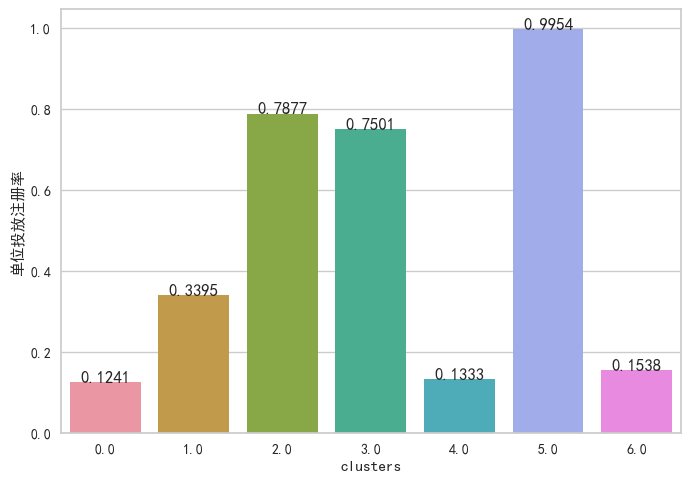

In [61]:
plt.rcParams['font.sans-serif'] = ['SimHei']#中文编码
sns.barplot(x=df_all.index,y=df_all['单位投放注册率'])
for x,y in zip(df_all.index,df_all['单位投放注册率']):
    plt.text(x=x,y=y,s='{:.4f}'.format(y),ha='center')

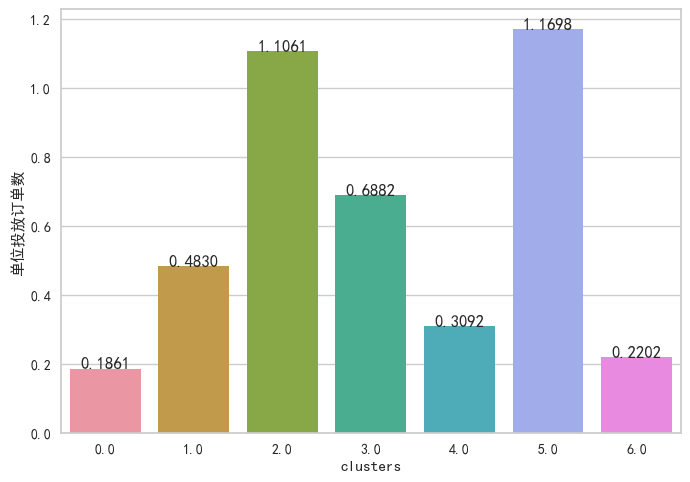

In [62]:
sns.barplot(x=df_all.index,y=df_all['单位投放订单数'])
for x,y in zip(df_all.index,df_all['单位投放订单数']):
    plt.text(x=x,y=y,s='{:.4f}'.format(y),ha='center')

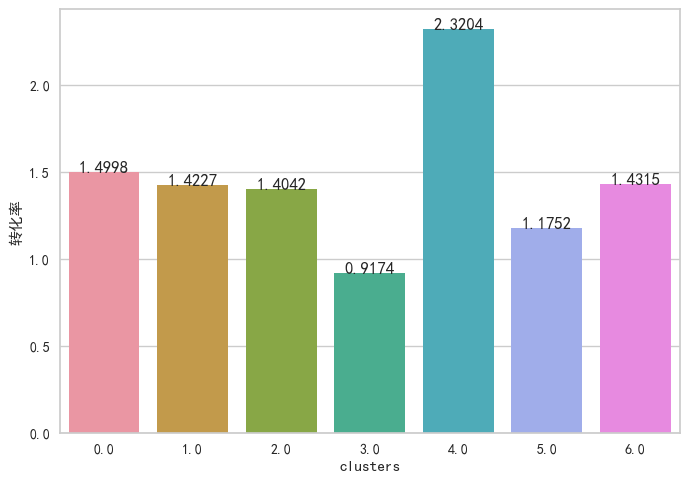

In [63]:
sns.barplot(x=df_all.index,y=df_all['转化率'])
for x,y in zip(df_all.index,df_all['转化率']):
    plt.text(x=x,y=y,s='{:.4f}'.format(y),ha='center')

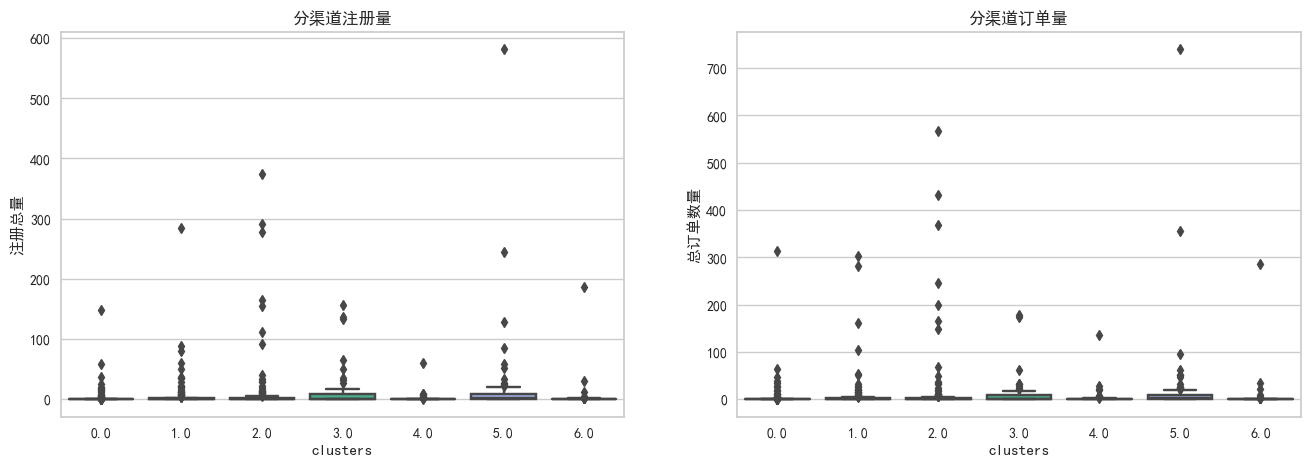

In [64]:
## 通过箱线图看看离群点
f = plt.figure(figsize=(16,5))
f.add_subplot(1,2,1)
sns.boxplot(x='clusters',y='注册总量',data=new_df).set_title('分渠道注册量')
f.add_subplot(1,2,2)
sns.boxplot(x='clusters',y='总订单数量',data=new_df).set_title('分渠道订单量')
plt.show()

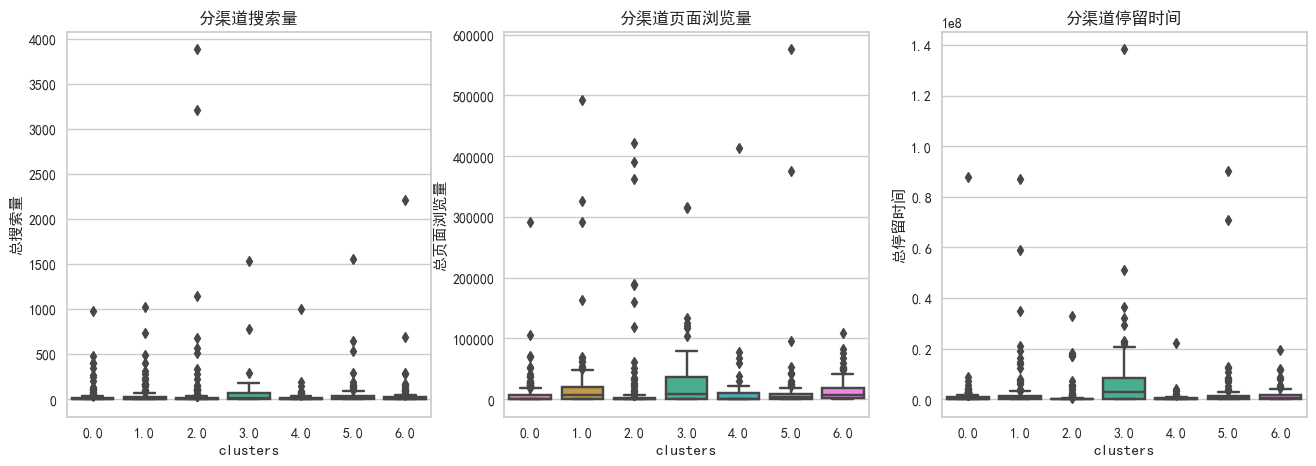

In [65]:
#剩余指标
f = plt.figure(figsize=(16,5))
f.add_subplot(1,3,1)
sns.boxplot(x='clusters',y='总搜索量',data=new_df).set_title('分渠道搜索量')
f.add_subplot(1,3,2)
sns.boxplot(x='clusters',y='总页面浏览量',data=new_df).set_title('分渠道页面浏览量')
f.add_subplot(1,3,3)
sns.boxplot(x='clusters',y='总停留时间',data=new_df).set_title('分渠道停留时间')
plt.show()

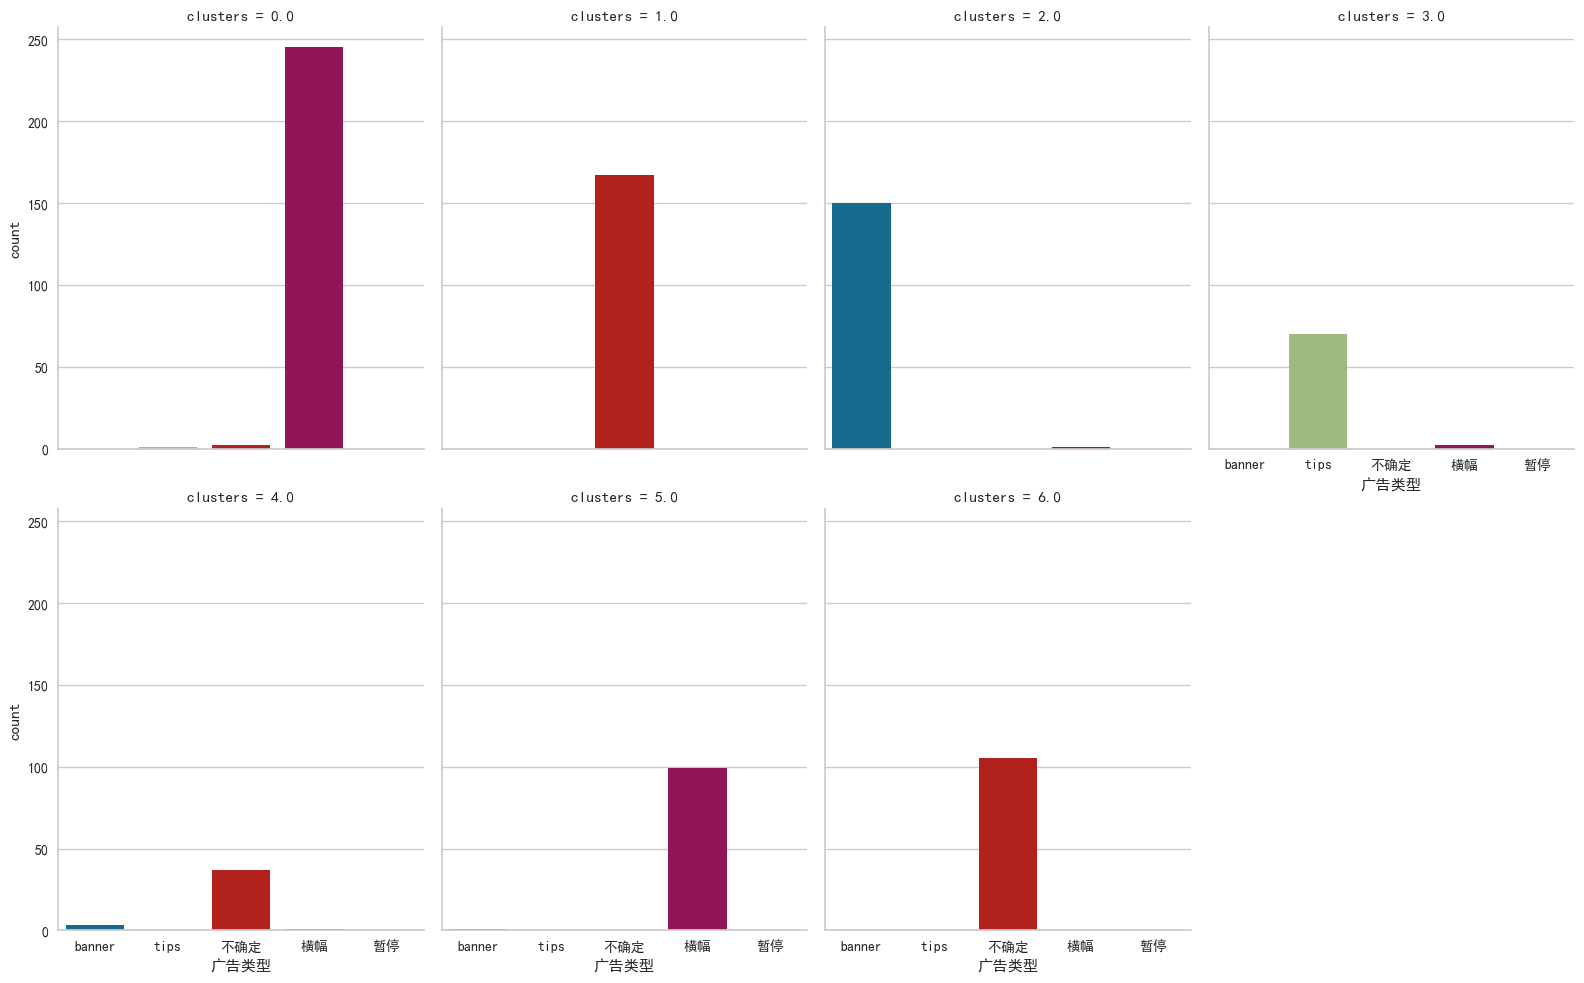

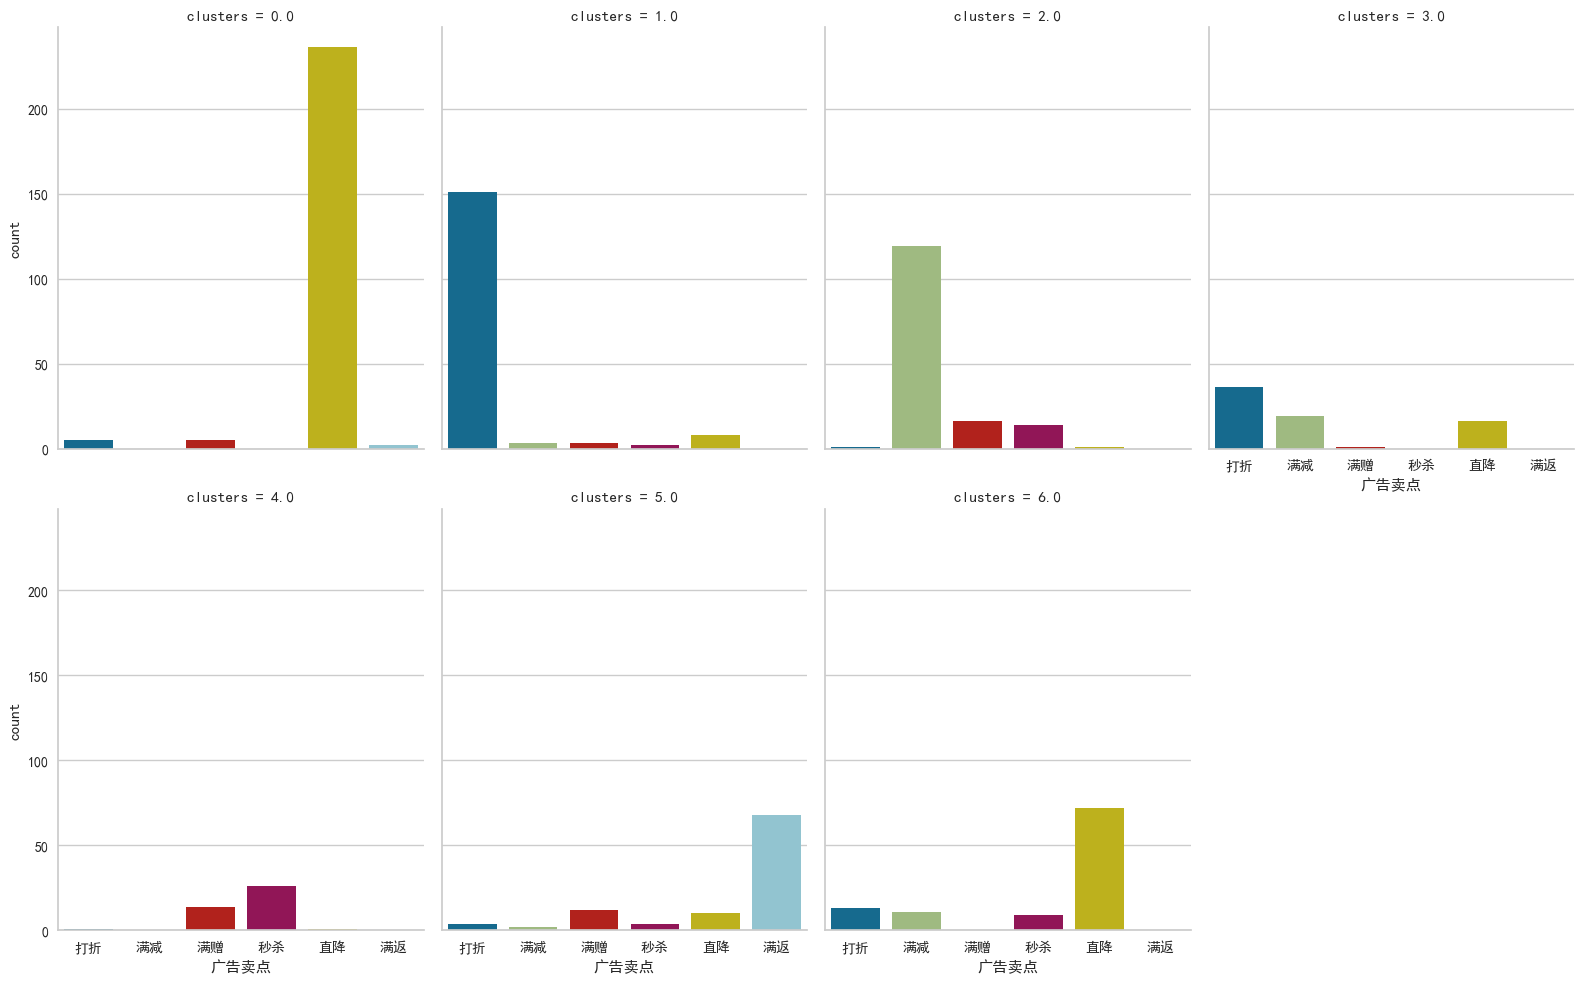

In [66]:
sns.catplot(x="广告类型", col="clusters", col_wrap=4,data=new_df,kind="count", height=5, aspect=.8)
sns.catplot(x="广告卖点", col="clusters", col_wrap=4,data=new_df,kind="count", height=5, aspect=.8)
plt.show()

In [ ]:
结论：
聚类1（标签0）：转化率高
投入高，产出低，但转化率较高，进一步分析这部分转化高的客户，从而削减其他无效投入，实现精准营销。
建议：降低投放比例

聚类2（标签1）：欠佳
投入高，属于主体渠道，但产出低
建议：低性价比，降低投放比例

聚类3（标签2）：优质渠道
引流注册效果好，转化效果好，存在搜索离群值，该类别中存在及其优质个体
建议：增加投放比例，可考虑作为主要投放渠道

聚类4（标签3）：欠佳
投入低，引流效果不错，但是转化效果不好
建议：考虑作为备选引流渠道，降低投入

聚类5（标签4）：转化率高
类似渠道1，投入不高，引流效果差，但是转化率最高，考虑进一步分析，实现精准营销
建议：尝试增加投放比例，进一步挖掘价值

聚类6（标签5）：优质渠道
投入不高，引流注册最高，转化效果较次，搜索量，浏览时间，停留时间处于平均水平，存在搜索离群值，该类别中存在及其优质个体，渠道网络
建议：增加投放比例，进一步挖掘价值

聚类7（标签6）：欠佳
投入中等，各指标表现欠佳
建议：降低投放比例